In [81]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
import re

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.manifold import TSNE
from sklearn.feature_extraction.text import TfidfVectorizer

import gensim

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout, Embedding, Flatten, Conv1D, MaxPooling1D, LSTM
from keras import utils
from keras.callbacks import ReduceLROnPlateau, EarlyStopping

In [82]:
data_columns = ["target", "ids", "date", "flag", "user", "text"]
data = pd.read_csv('/Users/steven/Desktop/PycharmProjects/SMDA/project/tweet_sentiment.csv', encoding='ISO-8859-1',names=data_columns)

In [83]:
decode_map = {0: "NEGATIVE", 2: "NEUTRAL", 4: "POSITIVE"}

def decode_sentiment(label):
    return decode_map[int(label)]

data.target = data.target.apply(lambda x: decode_sentiment(x))
data.head()

,target,ids,date,flag,user,text
0,NEGATIVE,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,NEGATIVE,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,NEGATIVE,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,NEGATIVE,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,NEGATIVE,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


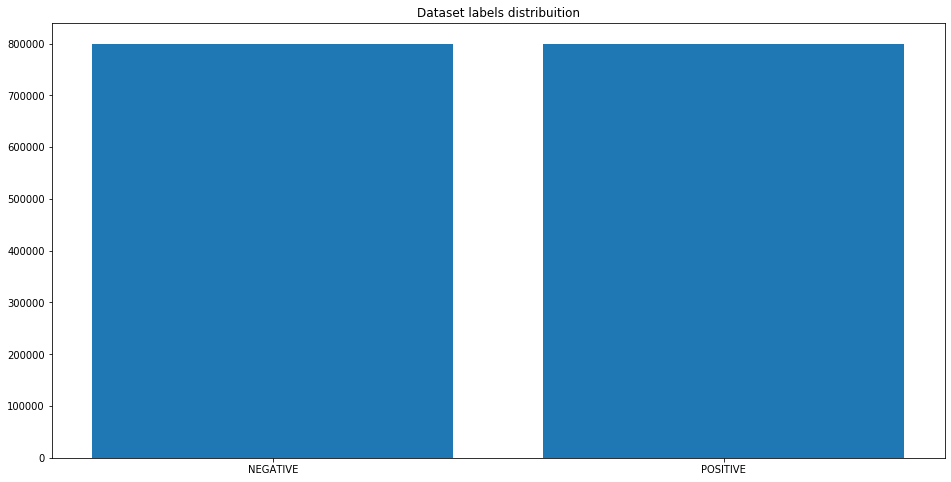

In [84]:
target_cnt = Counter(data.target)

plt.figure(figsize=(16,8))
plt.bar(target_cnt.keys(), target_cnt.values())
plt.title("Dataset labels distribuition")
plt.show()

In [85]:
TEXT_CLEANING_RE = "@\S+|https?:\S+|http?:\S|[^A-Za-z0-9]+"
stemmer = SnowballStemmer('english')
stop_words = stopwords.words("english")

def pre_process(text, stem=False):
    
    text = re.sub(TEXT_CLEANING_RE, ' ', str(text).lower()).strip()
    tokens = []
    for token in text.split():
        if token not in stop_words:
            if stem:
                tokens.append(stemmer.stem(token))
            else:
                tokens.append(token)
    return ' '.join(tokens)

In [86]:
data.text = data.text.apply(lambda x: pre_process(x))

In [87]:
data.text.head()

0         awww bummer shoulda got david carr third day
1    upset update facebook texting might cry result...
2    dived many times ball managed save 50 rest go ...
3                     whole body feels itchy like fire
4                                     behaving mad see
Name: text, dtype: object

# Split Train and Test

In [88]:
df_train, df_test = train_test_split(data, test_size=0.2, random_state=42)

print("TRAIN size:", len(df_train))
print("TEST size:", len(df_test))

TRAIN size: 1280000
TEST size: 320000


# Word to Vec

In [89]:
doc_train = [x.split() for x in df_train.text]

In [90]:
W2V_SIZE = 300
w2v_model = gensim.models.word2vec.Word2Vec(size=W2V_SIZE)
w2v_model.build_vocab(doc_train)

In [91]:
w2v_model.train(doc_train, total_examples=len(doc_train), epochs=32)

(267155090, 295270528)

In [139]:
w2v_model.wv.most_similar("fire")

[('firing', 0.3121594190597534),
 ('stove', 0.3113313913345337),
 ('fires', 0.31128209829330444),
 ('evacuated', 0.3025902807712555),
 ('drills', 0.3014261722564697),
 ('grills', 0.296565443277359),
 ('burning', 0.29130876064300537),
 ('trumpet', 0.2877410352230072),
 ('alarms', 0.27961429953575134),
 ('evacuate', 0.26365378499031067)]

# Tokenizer

In [93]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df_train.text)
vocab_size = len(tokenizer.word_index) + 1
print("Total words", vocab_size)

Total words 290419


# Set Train and Test dataset

In [94]:
x_train = pad_sequences(tokenizer.texts_to_sequences(df_train.text), maxlen=300)
x_test = pad_sequences(tokenizer.texts_to_sequences(df_test.text), maxlen=300)

# Label Encoder

In [95]:
labels = df_train.target.unique().tolist()
labels.append('NEUTRAL')
labels

['POSITIVE', 'NEGATIVE', 'NEUTRAL']

In [96]:
encoder = LabelEncoder()

encoder.fit(df_train.target.tolist())

y_train = encoder.transform(df_train.target.tolist())
y_test = encoder.transform(df_test.target.tolist())

y_train = y_train.reshape(-1,1)
y_test = y_test.reshape(-1,1)

print("y_train",y_train.shape)
print("y_test",y_test.shape)

y_train (1280000, 1)
y_test (320000, 1)


In [97]:
y_train[:10]

array([[1],
       [1],
       [1],
       [0],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1]])

# Embedding word from w2v

In [100]:
embedding_matrix = np.zeros((vocab_size, W2V_SIZE))
for word, i in tokenizer.word_index.items():
    if word in w2v_model.wv:
        embedding_matrix[i] = w2v_model.wv[word]
print(embedding_matrix.shape)

(290419, 300)


In [115]:
embedding_layer = Embedding(vocab_size, 
                            W2V_SIZE, 
                            weights=[embedding_matrix], 
                            input_length=300, 
                            trainable=False)

# Create the model

In [116]:
model = Sequential()
model.add(embedding_layer)
model.add(Dropout(0.5))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 300, 300)          87125700  
_________________________________________________________________
dropout_3 (Dropout)          (None, 300, 300)          0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 100)               160400    
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 101       
Total params: 87,286,201
Trainable params: 160,501
Non-trainable params: 87,125,700
_________________________________________________________________


In [117]:
model.compile(loss='binary_crossentropy',
              optimizer="adam",
              metrics=['accuracy'])

In [120]:
callbacks = [ ReduceLROnPlateau(monitor='val_loss', patience=5, cooldown=0),
              EarlyStopping(monitor='val_acc', min_delta=1e-4, patience=5)]

In [124]:
history = model.fit(x_train, y_train,
                    batch_size=1024,
                    epochs=4,
                    validation_split=0.1,
                    verbose=1,
                    callbacks=callbacks)

Train on 1152000 samples, validate on 128000 samples
Epoch 1/4
1152000/1152000 [==============================] - 5834s 5ms/step - loss: 0.4943 - accuracy: 0.7570 - val_loss: 0.4604 - val_accuracy: 0.7809
Epoch 2/4


/usr/local/lib/python3.7/site-packages/keras/callbacks/callbacks.py:846: RuntimeWarning: Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: val_loss,val_accuracy,loss,accuracy,lr
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning


1152000/1152000 [==============================] - 5400s 5ms/step - loss: 0.4798 - accuracy: 0.7666 - val_loss: 0.4536 - val_accuracy: 0.7852
Epoch 3/4
1152000/1152000 [==============================] - 5541s 5ms/step - loss: 0.4738 - accuracy: 0.7708 - val_loss: 0.4517 - val_accuracy: 0.7869
Epoch 4/4
1152000/1152000 [==============================] - 5429s 5ms/step - loss: 0.4705 - accuracy: 0.7728 - val_loss: 0.4491 - val_accuracy: 0.7878


# Print test data accuray and loss 

In [125]:
score = model.evaluate(x_test, y_test, batch_size=1024)
print("ACCURACY:",score[1])
print("LOSS:",score[0])

320000/320000 [==============================] - 476s 1ms/step
ACCURACY: 0.7890156507492065
LOSS: 0.4479480337142944


# Plot training and validation accuracy and loss

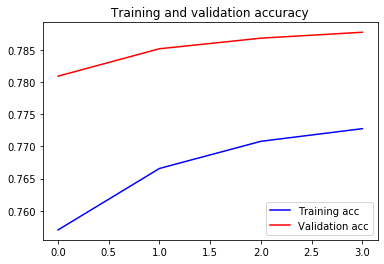

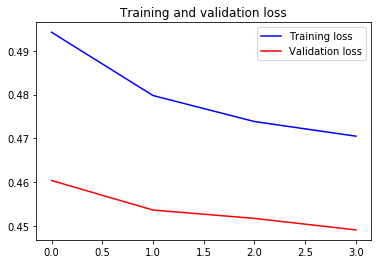

In [128]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
 
epochs = range(len(acc))
 
plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
 
plt.figure()
 
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
 
plt.show()

# Save model

In [133]:
import pickle

model.save("model.h5")
w2v_model.save('w2v_model.w2v')
with open('tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)
with open('encoder.pickle', 'wb') as handle:
    pickle.dump(encoder, handle, protocol=pickle.HIGHEST_PROTOCOL)